In [17]:
df = pd.read_csv('results.csv')
df

,Model,Descriptors,CV MAE,CV MAE STD,CV RMSE,CV RMSE STD,CV R2,CV R2 STD,Test MAE,Test RMSE,Test R2
0,CNN,Mordred,0.8439,0.0337,1.0913,0.0396,0.2364,0.0581,0.7389,0.9464,0.3893
1,CNN,RDKit,0.8087,0.0304,1.0638,0.0589,0.2630,0.0687,0.7704,1.0412,0.3208
2,MLP,Mordred,0.7771,0.0747,1.3122,0.4366,-0.2179,0.8930,0.6408,0.8717,0.4819
3,MLP,RDKit,0.7017,0.0432,0.9499,0.0464,0.4124,0.0479,0.6542,0.9180,0.4720
4,RandomForest,RDKit,0.7338,0.0151,0.9583,0.0201,0.4025,0.0184,0.7122,0.9146,0.4759
5,RandomForest,Mordred,0.7516,0.0118,0.9622,0.0232,0.4072,0.0241,0.7069,0.9006,0.4470
6,LightGBM,RDKit,0.6825,0.0145,0.9195,0.0226,0.4498,0.0238,0.6707,0.8778,0.5173
7,LightGBM,Mordred,0.6857,0.0158,0.9146,0.0327,0.4639,0.0372,0.6308,0.8284,0.5321


Выводы:


Лучшая комбинация

Модель: LightGBM

Дескрипторы: Mordred

Эта модель демонстрирует наилучшую обобщающую способность. Это говорит о том, что градиентный бустинг на деревьях (LightGBM) хорошо справляется с высокоразмерными и, возможно, избыточными дескрипторами, извлекая из них значимую информацию.

Лучшие нейросети
CNN + RDKit:

Test MAE = 0.7704

Test R² = 0.3208

MLP + RDKit:

Test MAE = 0.6542

Test R² = 0.4720

Нейросети (CNN, MLP) лучше работают с RDKit-дескрипторами, вероятно, из-за меньшей размерности и меньшей избыточности по сравнению с Mordred.




1. Подготовка данных

Используйте один или несколько файлов с дескрипторами, полученных в мини‑таске 2.
Выполните нормализацию/стандартизацию признаков:
возможно использование MinMaxScaler, StandardScaler, логарифмические преобразования и др.;
если необходимо, можно логарифмировать целевую переменную (standard_value → pIC50).
При желании можно уменьшить размерность пространства признаков с помощью:
PCA (главные компоненты),
t-SNE, UMAP (для визуализации/исследования структуры).
Конкретный выбор метода и параметров остается за вами — он должен быть обоснован в ноутбуке.

In [1]:
import pandas as pd
import numpy as np
df1_m_d = pd.read_csv('clean_mordred_descriptors_output_non_duplicates.csv')
df2_m_a = pd.read_csv('clean_mordred_descriptors_output_aggregated.csv')
df3_r_d = pd.read_csv('clean_rdkit_descriptors_output_non_dublicates.csv')
df4_r_a = pd.read_csv('clean_rdkit_descriptors_output_agr.csv')

# Вывод размерностей
print("df1_m_d (Mordred, non-aggregated):", df1_m_d.shape)
print("df2_m_a (Mordred, aggregated):", df2_m_a.shape)
print("df3_r_d (RDKit, non-aggregated):", df3_r_d.shape)
print("df4_r_a (RDKit, aggregated):", df4_r_a.shape)



df1_m_d (Mordred, non-aggregated): (4204, 173)
df2_m_a (Mordred, aggregated): (4205, 173)
df3_r_d (RDKit, non-aggregated): (4235, 112)
df4_r_a (RDKit, aggregated): (4205, 112)


In [ ]:
# !pip install lightgbm scikit-learn

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# ------------------------------------------------------------------------------
# 1) ВОСПРОИЗВОДИМОСТЬ
# ------------------------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ------------------------------------------------------------------------------
# 2) ЗАГРУЗКА ДАННЫХ
# ------------------------------------------------------------------------------
df = pd.read_csv(r"C:\Users\Redmi\Desktop\Биология\хакатон\RDKit_nonagg_pca_processed.csv")
X = df.drop(columns=['pIC50']).values.astype(np.float32)
y = df['pIC50'].values.astype(np.float32)

# ------------------------------------------------------------------------------
# 3) РАЗДЕЛЕНИЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
# ------------------------------------------------------------------------------
# stratify — не нужен, т.к. регрессия
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=SEED
)

# ------------------------------------------------------------------------------
# 4) ПОДБОР ПАРАМЕТРОВ НА ОБУЧАЮЩИХ ДАННЫХ (GridSearchCV + KFold)
# ------------------------------------------------------------------------------
param_grid = {
    'n_estimators':      [200, 500, 1000],
    'max_depth':         [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features':      ['sqrt', 'log2']
}

rf_base = RandomForestRegressor(random_state=SEED)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_trainval, y_trainval)

best_params = grid_search.best_params_
print("Лучшие параметры RandomForest:", best_params)

# ------------------------------------------------------------------------------
# 5) ОЦЕНКА СТАТИСТИК НА ОБУЧАЮЩЕЙ ВЫБОРКЕ С ЛУЧШИМИ ПАРАМЕТРАМИ
# ------------------------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
mae_scores, rmse_scores, r2_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
    y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

    rf = RandomForestRegressor(
        n_estimators=      best_params['n_estimators'],
        max_depth=         best_params['max_depth'],
        min_samples_split= best_params['min_samples_split'],
        max_features=      best_params['max_features'],
        random_state=      SEED,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mae   = mean_absolute_error(y_val, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_val, y_pred))
    r2    = r2_score(y_val, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")
# ------------------------------------------------------------------------------
# 6) ОБЩАЯ ОЦЕНКА НА КРОСС-ВАЛИДАЦИИ
# ------------------------------------------------------------------------------
print("\n=== Метрики на кросс-валидации (тренировочная часть) ===")
print(f"MAE : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"R²  : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


# ------------------------------------------------------------------------------
# 7) ФИНАЛЬНОЕ ОБУЧЕНИЕ И ТЕСТ
# ------------------------------------------------------------------------------
print("\n=== Финальная оценка на отложенной тестовой выборке ===")
rf_final = RandomForestRegressor(
    n_estimators=      best_params['n_estimators'],
    max_depth=         best_params['max_depth'],
    min_samples_split= best_params['min_samples_split'],
    max_features=      best_params['max_features'],
    random_state=      SEED,
    n_jobs=-1
)
rf_final.fit(X_trainval, y_trainval)
y_test_pred = rf_final.predict(X_test)

print("\n=== Финальная метрика на отложенной тестовой выборке ===")
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2   = r2_score(y_test, y_test_pred)

print(f"Test MAE : {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²  : {test_r2:.4f}")





Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры RandomForest: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000}

--- Fold 1 ---
MAE : 0.7240
RMSE: 0.9445
R²  : 0.4204

--- Fold 2 ---
MAE : 0.7166
RMSE: 0.9376
R²  : 0.3780

--- Fold 3 ---
MAE : 0.7574
RMSE: 0.9770
R²  : 0.3924

--- Fold 4 ---
MAE : 0.7453
RMSE: 0.9877
R²  : 0.3945

--- Fold 5 ---
MAE : 0.7260
RMSE: 0.9447
R²  : 0.4270

=== Метрики на кросс-валидации (тренировочная часть) ===
MAE : 0.7338 ± 0.0151
RMSE: 0.9583 ± 0.0201
R²  : 0.4025 ± 0.0184

=== Финальная оценка на отложенной тестовой выборке ===

=== Финальная метрика на отложенной тестовой выборке ===
Test MAE : 0.7122
Test RMSE: 0.9146
Test R²  : 0.4759


In [7]:

df5_rf_d = pd.read_csv('clean_output_non_duplicates_fing_with_rdkit.csv')
df6_rf_a = pd.read_csv('clean_output_aggregated_fing_with_rdkit.csv')

In [2]:
# Проверим количество выбросов

def count_outliers_iqr(X):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    is_outlier = (X < lower_bound) | (X > upper_bound)

    outliers_per_feature = is_outlier.sum()
    total_outliers = is_outlier.values.sum()

    total_values = X.shape[0] * X.shape[1]
    percent_outliers = (total_outliers / total_values) * 100

    return outliers_per_feature, total_outliers, percent_outliers

datasets = {
    'Mordred_nonagg': df1_m_d,
    'Mordred_agg'   : df2_m_a,
    'RDKit_nonagg'  : df3_r_d,
    'RDKit_agg'     : df4_r_a,
}

for name, df in datasets.items():
    X = df.drop(columns=['standard_value'])
    outliers_per_feature, total_outliers, percent_outliers = count_outliers_iqr(X)
    print(f"Датасет: {name}")
    print(f"  Всего выбросов: {total_outliers}")
    print(f"  Процент выбросов: {percent_outliers:.4f}%")
    print(f"  Выбросы по признакам (первые 10):\n{outliers_per_feature.head(10)}\n")


Датасет: Mordred_nonagg
  Всего выбросов: 29953
  Процент выбросов: 4.1424%
  Выбросы по признакам (первые 10):
nAcid          491
nBase          290
nAromAtom      166
nAtom          177
nSpiro          44
nBridgehead     13
nB               1
nN              80
nS              46
nP              55
dtype: int64

Датасет: Mordred_agg
  Всего выбросов: 29994
  Процент выбросов: 4.1471%
  Выбросы по признакам (первые 10):
nAcid          494
nBase          293
nAromAtom      166
nAtom          178
nSpiro          44
nBridgehead     13
nB               1
nN              80
nS              46
nP              55
dtype: int64

Датасет: RDKit_nonagg
  Всего выбросов: 20063
  Процент выбросов: 4.2680%
  Выбросы по признакам (первые 10):
MaxAbsEStateIndex    209
MinAbsEStateIndex    154
MinEStateIndex        11
qed                    0
SPS                  200
MolWt                218
FpDensityMorgan1     109
AvgIpc                26
BalabanJ             112
Ipc                  741
dtype: int6

In [ ]:
# Проверим количество выбросов у датасетов с фингепринтами

def count_outliers_iqr(X):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    is_outlier = (X < lower_bound) | (X > upper_bound)

    outliers_per_feature = is_outlier.sum()
    total_outliers = is_outlier.values.sum()

    total_values = X.shape[0] * X.shape[1]
    percent_outliers = (total_outliers / total_values) * 100

    return outliers_per_feature, total_outliers, percent_outliers

datasets = {
    'rdkit_fing_nonagg': df5_rf_d,
    'rdkit_fing_agg'   : df6_rf_a,
}

for name, df in datasets.items():
    X = df.drop(columns=['standard_value'])
    outliers_per_feature, total_outliers, percent_outliers = count_outliers_iqr(X)
    print(f"Датасет: {name}")
    print(f"  Всего выбросов: {total_outliers}")
    print(f"  Процент выбросов: {percent_outliers:.4f}%")
    print(f"  Выбросы по признакам (первые 10):\n{outliers_per_feature.head(10)}\n")


Датасет: rdkit_fing_nonagg
  Всего выбросов: 132527
  Процент выбросов: 1.6125%
  Выбросы по признакам (первые 10):
MaxAbsEStateIndex    207
MinAbsEStateIndex    150
MinEStateIndex        11
qed                    0
SPS                  193
MolWt                220
FpDensityMorgan1     109
AvgIpc                26
BalabanJ             112
Ipc                  738
dtype: int64

Датасет: rdkit_fing_agg
  Всего выбросов: 133170
  Процент выбросов: 1.6191%
  Выбросы по признакам (первые 10):
MaxAbsEStateIndex    209
MinAbsEStateIndex    152
MinEStateIndex        11
qed                    0
SPS                  196
MolWt                218
FpDensityMorgan1     123
AvgIpc                28
BalabanJ             112
Ipc                  739
dtype: int64



(4197, 94) Mordred_nonagg


c:\Users\Redmi\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


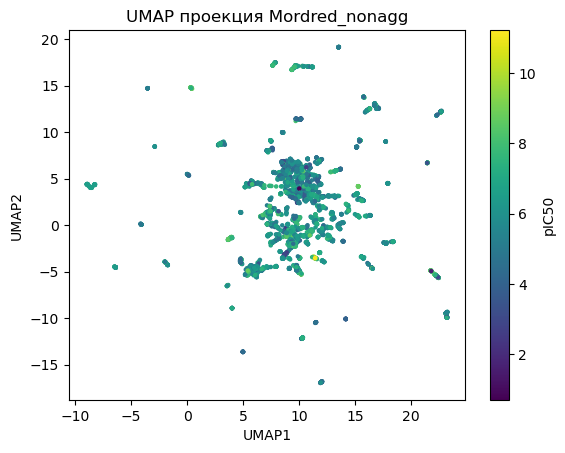

(4198, 94) Mordred_agg


c:\Users\Redmi\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


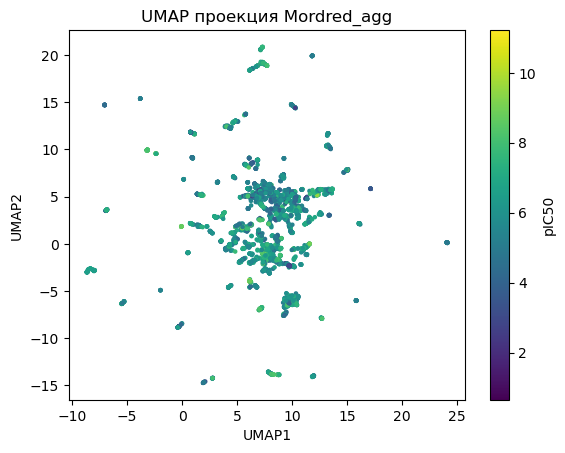

(4228, 75) RDKit_nonagg


c:\Users\Redmi\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


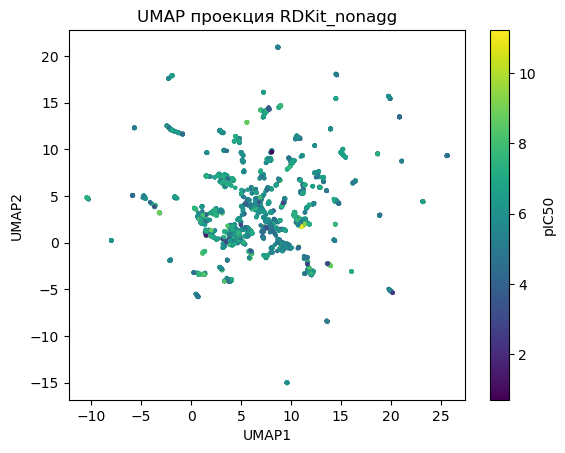

(4198, 75) RDKit_agg


c:\Users\Redmi\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


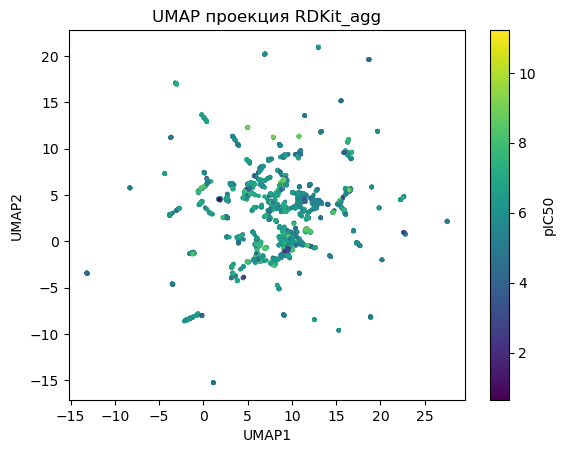

In [3]:


import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import umap.umap_ as umap


def preprocess(df, pca_variance=0.95):
    # убираем 0, так как невозможно логарифмировать
    df = df[df['standard_value'] > 0].copy()   # убрали 0 или <0
    # лог преобразование таргета IC50 нм переводим в М, затем pIC50
    # стабилизиует масштаб, стандартно используется
    y = -np.log10(df['standard_value'] * 1e-9)
    X = df.drop(columns=['standard_value'])

    # используем StandardScaler, т к выбросов немного около 4,5 процентов
    scaler_obj = StandardScaler()

    X_scaled = pd.DataFrame(scaler_obj.fit_transform(X), columns=X.columns)
    # 0.95 - популярное значение,признаки объясняют 95% дисперсии
    pca = PCA(n_components=pca_variance, svd_solver='full')
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, y, pca

# Пример применения к четырём датасетам:
datasets = {
    'Mordred_nonagg': df1_m_d,
    'Mordred_agg'   : df2_m_a,
    'RDKit_nonagg'  : df3_r_d,
    'RDKit_agg'     : df4_r_a,
}

results = {}
for name, df in datasets.items():
    X_pca, y, pca_model = preprocess(df)
    # Сохраняем в csv
    df_out = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    df_out['pIC50'] = y.values
    df_out.to_csv(f'{name}_pca_processed.csv', index=False)
    print(pd.read_csv(f'{name}_pca_processed.csv').shape, name)
    results[name] = (X_pca, y)

    # визуализация данных 
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(results[name][0])

    plt.scatter(embedding[:, 0], embedding[:, 1], c=results[name][1], s=5, cmap='viridis')
    plt.colorbar(label='pIC50')
    plt.title(f'UMAP проекция {name}')

    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()




(4197, 952) rdkit_fing_nonagg


c:\Users\Redmi\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


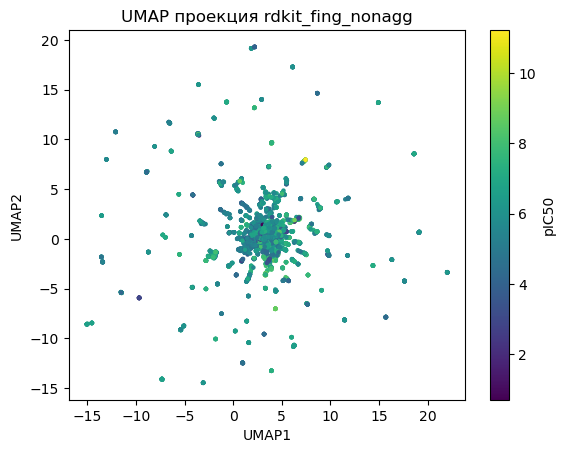

(4198, 950) rdkit_fing_agg


c:\Users\Redmi\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


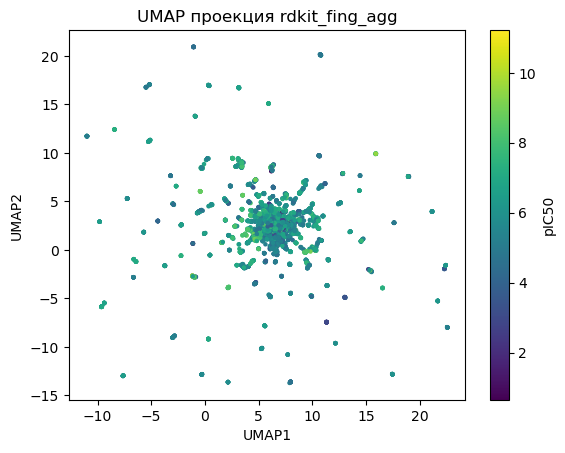

In [9]:


import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import umap.umap_ as umap


def preprocess(df, pca_variance=0.95):
    # убираем 0, так как невозможно логарифмировать
    df = df[df['standard_value'] > 0].copy()   # убрали 0 или <0
    # лог преобразование таргета IC50 нм переводим в М, затем pIC50
    # стабилизиует масштаб, стандартно используется
    y = -np.log10(df['standard_value'] * 1e-9)
    X = df.drop(columns=['standard_value'])

    # используем StandardScaler, т к выбросов немного около 4,5 процентов
    scaler_obj = StandardScaler()

    X_scaled = pd.DataFrame(scaler_obj.fit_transform(X), columns=X.columns)
    # 0.95 - популярное значение,признаки объясняют 95% дисперсии
    pca = PCA(n_components=pca_variance, svd_solver='full')
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, y, pca

# Пример применения к четырём датасетам:
datasets = {
    'rdkit_fing_nonagg': df5_rf_d,
    'rdkit_fing_agg'   : df6_rf_a,
}

results = {}
for name, df in datasets.items():
    X_pca, y, pca_model = preprocess(df)
    # Сохраняем в csv
    df_out = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
    df_out['pIC50'] = y.values
    df_out.to_csv(f'{name}_pca_processed.csv', index=False)
    print(pd.read_csv(f'{name}_pca_processed.csv').shape, name)
    results[name] = (X_pca, y)

    # визуализация данных 
    reducer = umap.UMAP(n_components=2, random_state=42)
    embedding = reducer.fit_transform(results[name][0])

    plt.scatter(embedding[:, 0], embedding[:, 1], c=results[name][1], s=5, cmap='viridis')
    plt.colorbar(label='pIC50')
    plt.title(f'UMAP проекция {name}')

    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()




2. Обучение моделей

Обучите не менее четырёх различных моделей:

Две классические модели машинного обучения, например:
Random Forest Regressor,
Gradient Boosting, XGBoost, LightGBM или аналогичные;
Две нейросетевые модели:
полносвязная сеть (MLP);
сверточная сеть (CNN).
Каждая модель должна быть обучена на одних и тех же данных для корректного сравнения.

Архитектура нейросетей подбирается самостоятельно. Можно использовать PyTorch, Keras, TensorFlow или другие фреймворки.

3. Воспроизводимость и стабильность

Установите random_seed для всех библиотек, чтобы обеспечить воспроизводимость.
Проверьте стабильность результатов:
с помощью кросс-валидации (например, KFold);
или путём повторного обучения с различными random_state.
Желательно сравнить не только средние метрики, но и разброс (дисперсию) результатов.

4. Сравнение результатов

Сравните модели по следующим аспектам:

метрики (например, MAE, RMSE, R²);
скорость обучения, интерпретируемость, переобучение;
чувствительность к типу дескрипторов;
необходимость предобработки или отбора признаков.
Сделайте выводы, какие комбинации (модель + дескрипторы) работают лучше всего, и почему.

Обоснование выбора признаков, модели и параметров


В качестве признаков выбраны дескрипторы RDKit и Mordred, как наиболее распространенные. 


Выбор модели Random Forest Regressor обусловлен её устойчивостью к переобучению, способностью работать с высокоразмерными признаками и малым числом гиперпараметров. 


Гиперпараметры (n_estimators, max_depth, min_samples_split, max_features) подбирались с помощью GridSearchCV с 5-кратной кросс-валидацией для повышения обобщающей способности модели.


Для регрессии выбрана модель LightGBM, так как она: эффективно работает с числовыми признаками, обеспечивает высокую точность за счёт градиентного бустинга, хорошо масштабируется и быстрее обучается, чем другие ансамбли (например, XGBoost или Random Forest).


Гиперпараметры (n_estimators, max_depth, learning_rate, num_leaves, subsample, colsample_bytree) подбирались с помощью GridSearchCV с 5-кратной кросс-валидацией для оптимизации по метрике MAE. 

ДАлее следуют два одинаковых кода для разных датасетов RandomForestRegressor: дескрипторы RDKIT, дескрипторы MOrdred

In [ ]:
# !pip install lightgbm scikit-learn

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# ------------------------------------------------------------------------------
# 1) ВОСПРОИЗВОДИМОСТЬ
# ------------------------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ------------------------------------------------------------------------------
# 2) ЗАГРУЗКА ДАННЫХ
# ------------------------------------------------------------------------------
df = pd.read_csv(r"C:\Users\Redmi\Desktop\Биология\хакатон\RDKit_nonagg_pca_processed.csv")
X = df.drop(columns=['pIC50']).values.astype(np.float32)
y = df['pIC50'].values.astype(np.float32)

# ------------------------------------------------------------------------------
# 3) РАЗДЕЛЕНИЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
# ------------------------------------------------------------------------------
# stratify — не нужен, т.к. регрессия
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=SEED
)

# ------------------------------------------------------------------------------
# 4) ПОДБОР ПАРАМЕТРОВ НА ОБУЧАЮЩИХ ДАННЫХ (GridSearchCV + KFold)
# ------------------------------------------------------------------------------
param_grid = {
    'n_estimators':      [200, 500, 1000],
    'max_depth':         [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features':      ['sqrt', 'log2']
}

rf_base = RandomForestRegressor(random_state=SEED)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_trainval, y_trainval)

best_params = grid_search.best_params_
print("Лучшие параметры RandomForest:", best_params)

# ------------------------------------------------------------------------------
# 5) ОЦЕНКА СТАТИСТИК НА ОБУЧАЮЩЕЙ ВЫБОРКЕ С ЛУЧШИМИ ПАРАМЕТРАМИ
# ------------------------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
mae_scores, rmse_scores, r2_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
    y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

    rf = RandomForestRegressor(
        n_estimators=      best_params['n_estimators'],
        max_depth=         best_params['max_depth'],
        min_samples_split= best_params['min_samples_split'],
        max_features=      best_params['max_features'],
        random_state=      SEED,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mae   = mean_absolute_error(y_val, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_val, y_pred))
    r2    = r2_score(y_val, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")
# ------------------------------------------------------------------------------
# 6) ОБЩАЯ ОЦЕНКА НА КРОСС-ВАЛИДАЦИИ
# ------------------------------------------------------------------------------
print("\n=== Метрики на кросс-валидации (тренировочная часть) ===")
print(f"MAE : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"R²  : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


# ------------------------------------------------------------------------------
# 7) ФИНАЛЬНОЕ ОБУЧЕНИЕ И ТЕСТ
# ------------------------------------------------------------------------------
print("\n=== Финальная оценка на отложенной тестовой выборке ===")
rf_final = RandomForestRegressor(
    n_estimators=      best_params['n_estimators'],
    max_depth=         best_params['max_depth'],
    min_samples_split= best_params['min_samples_split'],
    max_features=      best_params['max_features'],
    random_state=      SEED,
    n_jobs=-1
)
rf_final.fit(X_trainval, y_trainval)
y_test_pred = rf_final.predict(X_test)

print("\n=== Финальная метрика на отложенной тестовой выборке ===")
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2   = r2_score(y_test, y_test_pred)

print(f"Test MAE : {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²  : {test_r2:.4f}")





Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры RandomForest: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000}

--- Fold 1 ---
MAE : 0.7240
RMSE: 0.9445
R²  : 0.4204

--- Fold 2 ---
MAE : 0.7166
RMSE: 0.9376
R²  : 0.3780

--- Fold 3 ---
MAE : 0.7574
RMSE: 0.9770
R²  : 0.3924

--- Fold 4 ---
MAE : 0.7453
RMSE: 0.9877
R²  : 0.3945

--- Fold 5 ---
MAE : 0.7260
RMSE: 0.9447
R²  : 0.4270

=== Метрики на кросс-валидации (тренировочная часть) ===
MAE : 0.7338 ± 0.0151
RMSE: 0.9583 ± 0.0201
R²  : 0.4025 ± 0.0184

=== Финальная оценка на отложенной тестовой выборке ===

=== Финальная метрика на отложенной тестовой выборке ===
Test MAE : 0.7122
Test RMSE: 0.9146
Test R²  : 0.4759


In [ ]:
# !pip install lightgbm scikit-learn

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# ------------------------------------------------------------------------------
# 1) ВОСПРОИЗВОДИМОСТЬ
# ------------------------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ------------------------------------------------------------------------------
# 2) ЗАГРУЗКА ДАННЫХ
# ------------------------------------------------------------------------------
df = pd.read_csv(r"C:\Users\Redmi\Desktop\Биология\хакатон\Mordred_nonagg_pca_processed.csv")
X = df.drop(columns=['pIC50']).values.astype(np.float32)
y = df['pIC50'].values.astype(np.float32)

# ------------------------------------------------------------------------------
# 3) РАЗДЕЛЕНИЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
# ------------------------------------------------------------------------------
# stratify — не нужен, т.к. регрессия
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=SEED
)

# ------------------------------------------------------------------------------
# 4) ПОДБОР ПАРАМЕТРОВ НА ОБУЧАЮЩИХ ДАННЫХ (GridSearchCV + KFold)
# ------------------------------------------------------------------------------
param_grid = {
    'n_estimators':      [200, 500, 1000],
    'max_depth':         [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features':      ['sqrt', 'log2']
}

rf_base = RandomForestRegressor(random_state=SEED)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_trainval, y_trainval)

best_params = grid_search.best_params_
print("Лучшие параметры RandomForest:", best_params)

# ------------------------------------------------------------------------------
# 5) ОЦЕНКА СТАТИСТИК НА ОБУЧАЮЩЕЙ ВЫБОРКЕ С ЛУЧШИМИ ПАРАМЕТРАМИ
# ------------------------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
mae_scores, rmse_scores, r2_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
    y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

    rf = RandomForestRegressor(
        n_estimators=      best_params['n_estimators'],
        max_depth=         best_params['max_depth'],
        min_samples_split= best_params['min_samples_split'],
        max_features=      best_params['max_features'],
        random_state=      SEED,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    mae   = mean_absolute_error(y_val, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_val, y_pred))
    r2    = r2_score(y_val, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")
# ------------------------------------------------------------------------------
# 6) ОБЩАЯ ОЦЕНКА НА КРОСС-ВАЛИДАЦИИ
# ------------------------------------------------------------------------------
print("\n=== Метрики на кросс-валидации (тренировочная часть) ===")
print(f"MAE : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"R²  : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")


# ------------------------------------------------------------------------------
# 7) ФИНАЛЬНОЕ ОБУЧЕНИЕ И ТЕСТ
# ------------------------------------------------------------------------------
print("\n=== Финальная оценка на отложенной тестовой выборке ===")
rf_final = RandomForestRegressor(
    n_estimators=      best_params['n_estimators'],
    max_depth=         best_params['max_depth'],
    min_samples_split= best_params['min_samples_split'],
    max_features=      best_params['max_features'],
    random_state=      SEED,
    n_jobs=-1
)
rf_final.fit(X_trainval, y_trainval)
y_test_pred = rf_final.predict(X_test)

print("\n=== Финальная метрика на отложенной тестовой выборке ===")
test_mae  = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2   = r2_score(y_test, y_test_pred)

print(f"Test MAE : {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²  : {test_r2:.4f}")





Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры RandomForest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}

--- Fold 1 ---
MAE : 0.7325
RMSE: 0.9282
R²  : 0.4206

--- Fold 2 ---
MAE : 0.7656
RMSE: 0.9857
R²  : 0.4078

--- Fold 3 ---
MAE : 0.7449
RMSE: 0.9463
R²  : 0.4447

--- Fold 4 ---
MAE : 0.7602
RMSE: 0.9894
R²  : 0.3817

--- Fold 5 ---
MAE : 0.7546
RMSE: 0.9617
R²  : 0.3811

=== Метрики на кросс-валидации (тренировочная часть) ===
MAE : 0.7516 ± 0.0118
RMSE: 0.9622 ± 0.0232
R²  : 0.4072 ± 0.0241

=== Финальная оценка на отложенной тестовой выборке ===

=== Финальная метрика на отложенной тестовой выборке ===
Test MAE : 0.7069
Test RMSE: 0.9006
Test R²  : 0.4470


Далее следуют два одинаковых кода lightgbm для двух датасетов аналогично предыдущей моделе

In [ ]:
!pip install lightgbm scikit-learn

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# --------------------------------------------------------------------------
# 1) ВОСПРОИЗВОДИМОСТЬ
# --------------------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# --------------------------------------------------------------------------
# 2) ЗАГРУЗКА ДАННЫХ
# --------------------------------------------------------------------------
df = pd.read_csv(r"C:\Users\Redmi\Desktop\Биология\хакатон\Mordred_nonagg_pca_processed.csv")
X = df.drop(columns=['pIC50']).values.astype(np.float32)
y = df['pIC50'].values.astype(np.float32)

# --------------------------------------------------------------------------
# 3) РАЗДЕЛЕНИЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
# --------------------------------------------------------------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=SEED
)

# --------------------------------------------------------------------------
# 4) ПОДБОР ПАРАМЕТРОВ НА ОБУЧАЮЩИХ ДАННЫХ
# --------------------------------------------------------------------------
param_grid = {
    'n_estimators': [100, 200, 500],          
    'max_depth': [-1, 10],                     
    'learning_rate': [0.01, 0.05],            
    'num_leaves': [31, 50, 100],               
    'subsample': [0.8],                        
    'colsample_bytree': [0.8]                  
}
lgbm_base = LGBMRegressor(random_state=SEED, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=lgbm_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_trainval, y_trainval)

best_params = grid_search.best_params_
print("Лучшие параметры LightGBM:", best_params)

# --------------------------------------------------------------------------
# 5) ОЦЕНКА СТАТИСТИК НА ОБУЧАЮЩЕЙ ВЫБОРКЕ С ЛУЧШИМИ ПАРАМЕТРАМИ
# --------------------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
mae_scores, rmse_scores, r2_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
    y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

    lgbm = LGBMRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")

# --------------------------------------------------------------------------
# 6) ОБЩАЯ ОЦЕНКА НА КРОСС-ВАЛИДАЦИИ
# --------------------------------------------------------------------------
print("\n=== Метрики на кросс-валидации (тренировочная часть) ===")
print(f"MAE : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"R²  : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

# --------------------------------------------------------------------------
# 7) ФИНАЛЬНОЕ ОБУЧЕНИЕ И ТЕСТ
# --------------------------------------------------------------------------
print("\n=== Финальная оценка на отложенной тестовой выборке ===")
lgbm_final = LGBMRegressor(
    **best_params,
    random_state=SEED,
    n_jobs=-1
)
lgbm_final.fit(X_trainval, y_trainval)
y_test_pred = lgbm_final.predict(X_test)

print("\n=== Финальная метрика на отложенной тестовой выборке ===")
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MAE : {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²  : {test_r2:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23715
[LightGBM] [Info] Number of data points in the train set: 3357, number of used features: 93
[LightGBM] [Info] Start training from score 6.092432
Лучшие параметры LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 50, 'subsample': 0.8}

--- Fold 1 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23715
[LightGBM] [Info] Number of data points in the train set: 2685, number of used features: 93
[LightGBM] [Info] Start training from score 6.094999


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.6694
RMSE: 0.8772
R²  : 0.4825

--- Fold 2 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23715
[LightGBM] [Info] Number of data points in the train set: 2685, number of used features: 93
[LightGBM] [Info] Start training from score 6.085487


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.7056
RMSE: 0.9363
R²  : 0.4657

--- Fold 3 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23715
[LightGBM] [Info] Number of data points in the train set: 2686, number of used features: 93
[LightGBM] [Info] Start training from score 6.101045


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.6651
RMSE: 0.8779
R²  : 0.5221

--- Fold 4 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23715
[LightGBM] [Info] Number of data points in the train set: 2686, number of used features: 93
[LightGBM] [Info] Start training from score 6.087650


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.6968
RMSE: 0.9601
R²  : 0.4178

--- Fold 5 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23715
[LightGBM] [Info] Number of data points in the train set: 2686, number of used features: 93
[LightGBM] [Info] Start training from score 6.092976


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.6917
RMSE: 0.9217
R²  : 0.4315

=== Метрики на кросс-валидации (тренировочная часть) ===
MAE : 0.6857 ± 0.0158
RMSE: 0.9146 ± 0.0327
R²  : 0.4639 ± 0.0372

=== Финальная оценка на отложенной тестовой выборке ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23715
[LightGBM] [Info] Number of data points in the train set: 3357, number of used features: 93
[LightGBM] [Info] Start training from score 6.092432

=== Финальная метрика на отложенной тестовой выборке ===
Test MAE : 0.6308
Test RMSE: 0.8284
Test R²  : 0.5321


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
!pip install lightgbm scikit-learn

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# --------------------------------------------------------------------------
# 1) ВОСПРОИЗВОДИМОСТЬ
# --------------------------------------------------------------------------
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# --------------------------------------------------------------------------
# 2) ЗАГРУЗКА ДАННЫХ
# --------------------------------------------------------------------------
df = pd.read_csv(r"C:\Users\Redmi\Desktop\Биология\хакатон\RDKit_nonagg_pca_processed.csv")
X = df.drop(columns=['pIC50']).values.astype(np.float32)
y = df['pIC50'].values.astype(np.float32)

# --------------------------------------------------------------------------
# 3) РАЗДЕЛЕНИЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
# --------------------------------------------------------------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=SEED
)

# --------------------------------------------------------------------------
# 4) ПОДБОР ПАРАМЕТРОВ НА ОБУЧАЮЩИХ ДАННЫХ
# --------------------------------------------------------------------------
param_grid = {
    'n_estimators': [100, 200, 500],          
    'max_depth': [-1, 10],                     
    'learning_rate': [0.01, 0.05],            
    'num_leaves': [31, 50, 100],               
    'subsample': [0.8],                        
    'colsample_bytree': [0.8]                  
}
lgbm_base = LGBMRegressor(random_state=SEED, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=lgbm_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_trainval, y_trainval)

best_params = grid_search.best_params_
print("Лучшие параметры LightGBM:", best_params)

# --------------------------------------------------------------------------
# 5) ОЦЕНКА СТАТИСТИК НА ОБУЧАЮЩЕЙ ВЫБОРКЕ С ЛУЧШИМИ ПАРАМЕТРАМИ
# --------------------------------------------------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
mae_scores, rmse_scores, r2_scores = [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
    y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

    lgbm = LGBMRegressor(
        **best_params,
        random_state=SEED,
        n_jobs=-1
    )
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")

# --------------------------------------------------------------------------
# 6) ОБЩАЯ ОЦЕНКА НА КРОСС-ВАЛИДАЦИИ
# --------------------------------------------------------------------------
print("\n=== Метрики на кросс-валидации (тренировочная часть) ===")
print(f"MAE : {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
print(f"RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"R²  : {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

# --------------------------------------------------------------------------
# 7) ФИНАЛЬНОЕ ОБУЧЕНИЕ И ТЕСТ
# --------------------------------------------------------------------------
print("\n=== Финальная оценка на отложенной тестовой выборке ===")
lgbm_final = LGBMRegressor(
    **best_params,
    random_state=SEED,
    n_jobs=-1
)
lgbm_final.fit(X_trainval, y_trainval)
y_test_pred = lgbm_final.predict(X_test)

print("\n=== Финальная метрика на отложенной тестовой выборке ===")
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MAE : {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R²  : {test_r2:.4f}")


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 3382, number of used features: 74
[LightGBM] [Info] Start training from score 6.074237
Лучшие параметры LightGBM: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.8}

--- Fold 1 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 2705, number of used features: 74
[LightGBM] [Info] Start training from score 6.084088


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.6738
RMSE: 0.8957
R²  : 0.4787

--- Fold 2 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 2705, number of used features: 74
[LightGBM] [Info] Start training from score 6.062026


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.6642
RMSE: 0.9056
R²  : 0.4199

--- Fold 3 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 74
[LightGBM] [Info] Start training from score 6.067088


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.7025
RMSE: 0.9431
R²  : 0.4338

--- Fold 4 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 74
[LightGBM] [Info] Start training from score 6.075527


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.6961
RMSE: 0.9503
R²  : 0.4395

--- Fold 5 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 2706, number of used features: 74
[LightGBM] [Info] Start training from score 6.082455


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE : 0.6756
RMSE: 0.9027
R²  : 0.4768

=== Метрики на кросс-валидации (тренировочная часть) ===
MAE : 0.6825 ± 0.0145
RMSE: 0.9195 ± 0.0226
R²  : 0.4498 ± 0.0238

=== Финальная оценка на отложенной тестовой выборке ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18870
[LightGBM] [Info] Number of data points in the train set: 3382, number of used features: 74
[LightGBM] [Info] Start training from score 6.074237

=== Финальная метрика на отложенной тестовой выборке ===
Test MAE : 0.6707
Test RMSE: 0.8778
Test R²  : 0.5173


c:\Users\Redmi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
